In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report , make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
import timeit
from sklearn.model_selection import cross_val_score
import pickle


In [2]:
df = pd.read_csv("ddos.csv")

In [3]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,188912,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
1,6,183,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
2,6,168997,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
3,6,151583,4,2,24.0,12.0,6.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP
4,17,3,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,LDAP


# Analyse de Forme :

In [4]:
df.shape
#df.info()

(1245753, 80)

In [5]:
df.dtypes.value_counts()

float64    45
int64      34
object      1
dtype: int64

In [6]:
df[' Label'].value_counts()

LDAP       200000
NetBIOS    200000
MSSQL      200000
UDP        200000
Syn        199997
Portmap    186960
BENIGN      56923
UDPLag       1873
Name:  Label, dtype: int64

Text(0.5, 1.0, 'Class Distributions ')

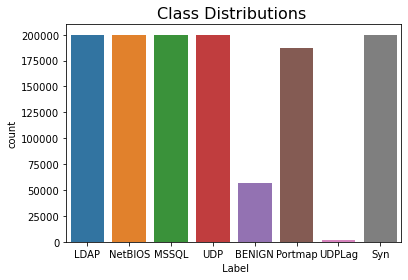

In [7]:
sns.countplot(x=' Label',data=df)
plt.title('Class Distributions ', fontsize=16)


# Preprocessing :

In [3]:

def encodage(df):
    code ={'BENIGN':0, 
       'LDAP': 1,
       'NetBIOS':2,
       'MSSQL':3,
       'UDP':4,
       'Portmap':2,
       'UDPLag':5,
       'Syn':6
       }
    
    df[' Label'] = df[' Label'].map(code)
   
    return df

df.dtypes.value_counts()
df[' Label'].value_counts()

LDAP       200000
NetBIOS    200000
MSSQL      200000
UDP        200000
Syn        199997
Portmap    186960
BENIGN      56923
UDPLag       1873
Name:  Label, dtype: int64

In [4]:
df = encodage(df)   
y = df[' Label'] 
X= df.drop(' Label', axis=1)

In [5]:
X = X.astype('float64')
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [6]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros= ros.fit_resample(X, y)
y_ros.value_counts()

1    386960
2    386960
3    386960
4    386960
0    386960
5    386960
6    386960
Name:  Label, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=4)

# Modellisation :

In [13]:
Svm = LinearSVC(multi_class='ovr')
Knn = KNeighborsClassifier()
DecisionTree = DecisionTreeClassifier(random_state=0)
LogReg = LogisticRegression(multi_class='multinomial')
GaussNB = GaussianNB()

In [14]:
dict_of_models = {
                  'DecisionTree': DecisionTree,
                  'SVM': Svm,
                  'KNN': Knn,                  
                  'LogReg' : LogReg,
                  'GaussNB': GaussNB
                  }


# Procédure d'évaluation :

In [8]:
def evaluation_test(model,name=None):
    
    if name is None:
        name = model.__class__.__name__

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    # Train the model on the full training set
    start_time = timeit.default_timer()
    
    model.fit(X_train, y_train)
    

    # Make predictions on test data (X_test)
    ypred = model.predict(X_test)

    # plot confusion matrix
    cf_matrix = confusion_matrix(y_test, ypred)
    sns.heatmap(cf_matrix, annot=True, fmt=".0f", ax=axes[0])
    axes[0].set_title(f"{name} Confusion Matrix")

    # plot classification report
    report = classification_report(y_test, ypred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df, annot=True, cmap='Blues', ax=axes[1])
    axes[1].set_title(f"{name} Classification Report")

    # plot normalized confusion matrix
    cm_normalized = cf_matrix/np.sum(cf_matrix, axis=1).reshape(-1,1)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', ax=axes[2])
    axes[2].set_title(f"{name} Normalized Confusion Matrix")

    # Plot cross-validation scores
    scorer = make_scorer(f1_score, average='micro')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
    print(f"{name} Cross-Validation Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")
    print(f"Standard Deviation: {np.std(scores)}")
    elapsed_time = timeit.default_timer() - start_time

    print(f"Elapsed Time (s): {elapsed_time:.4f}")
    plt.show()
    

    # Save the model to a file
    with open('model_'+name+'.pkl', 'wb') as file:
        pickle.dump(model, file)
    

DecisionTree Cross-Validation Scores: [0.98910235 0.98951765 0.98943458 0.98982914 0.98936305]
Mean Score: 0.9894493526218138
Standard Deviation: 0.00023536451919378533
Elapsed Time (s): 420.8578


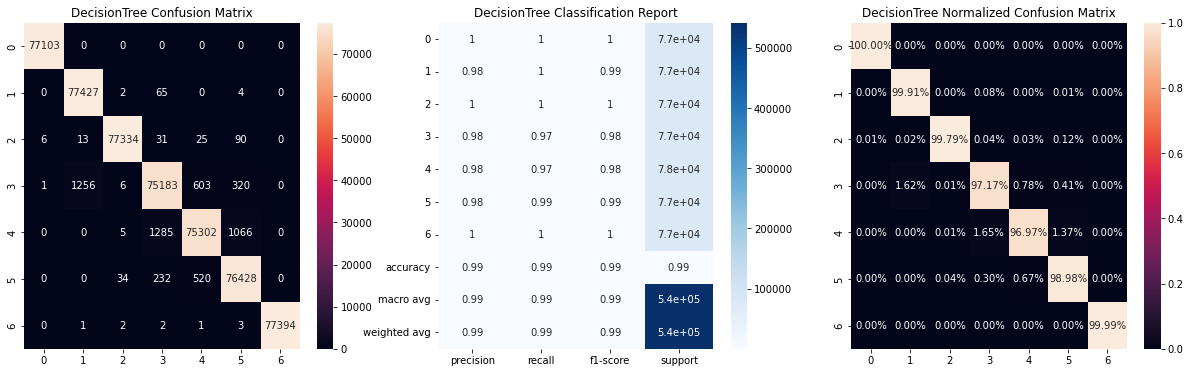

SVM Cross-Validation Scores: [0.86063554 0.86009991 0.86223884 0.88084773 0.85983456]
Mean Score: 0.8647313140965915
Standard Deviation: 0.00810129172643894
Elapsed Time (s): 43230.2469


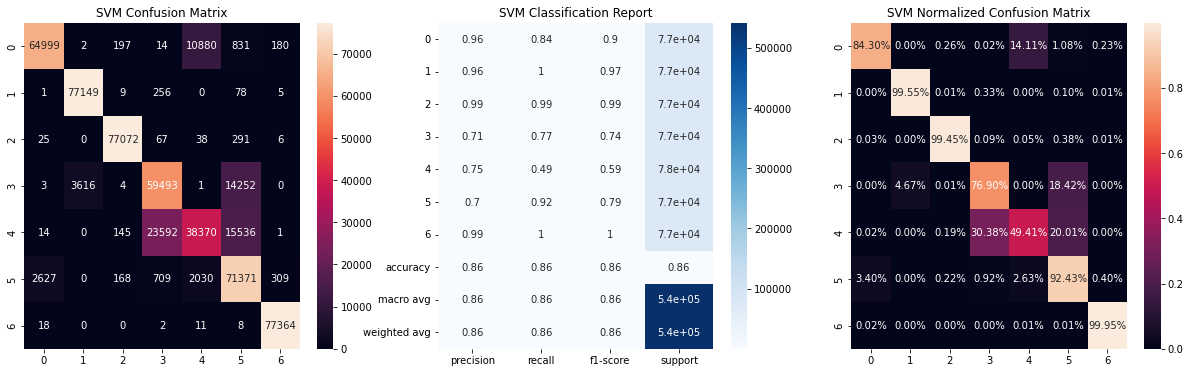

KNN Cross-Validation Scores: [0.9884609  0.98765099 0.98766714 0.9880617  0.98726797]
Mean Score: 0.9878217383860453
Standard Deviation: 0.0004064058488472211
Elapsed Time (s): 10908.8521


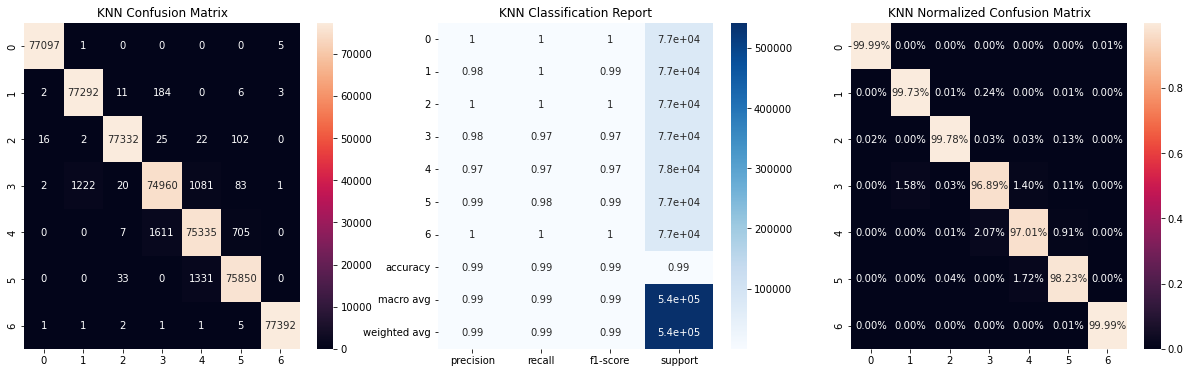

LogReg Cross-Validation Scores: [0.9259684  0.92367932 0.92381084 0.92319708 0.92345089]
Mean Score: 0.9240213080592078
Standard Deviation: 0.0009957037362671275
Elapsed Time (s): 490.8374


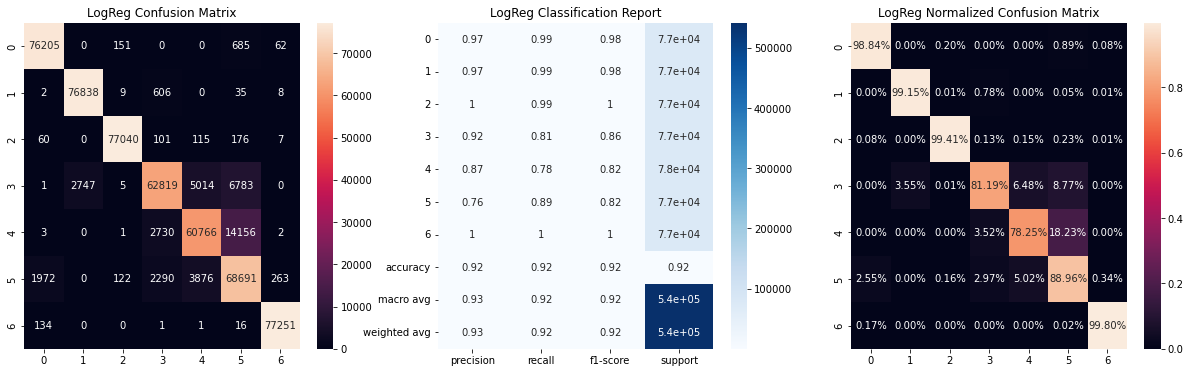

MemoryError: Unable to allocate 2.79 TiB for an array with shape (619319, 619319) and data type float64

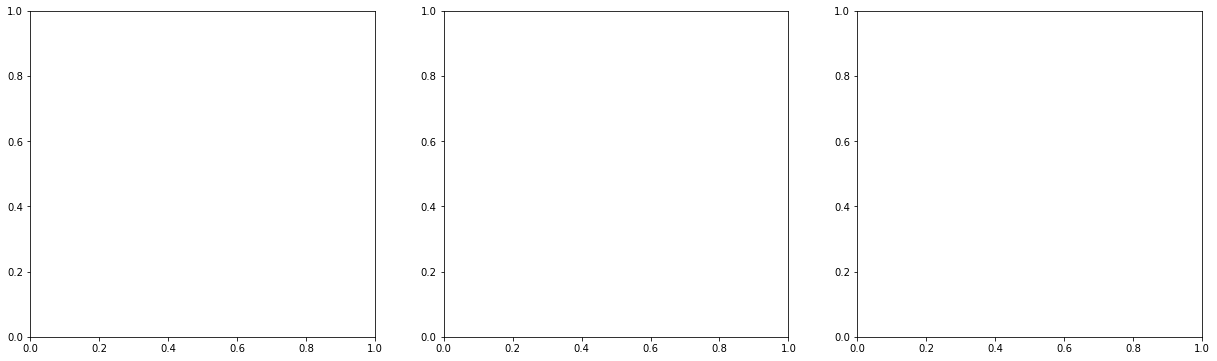

In [16]:
# Iterate over all models in dict_of_models
for name, model in dict_of_models.items():
    evaluation_test(model,name)
    

In [11]:
GaussNB = GaussianNB()

GaussNB Cross-Validation Scores: [0.66067061 0.6591262  0.6608175  0.65895546 0.66013683]
Mean Score: 0.6599413188105028
Standard Deviation: 0.0007712487574785009
Elapsed Time (s): 37.6611


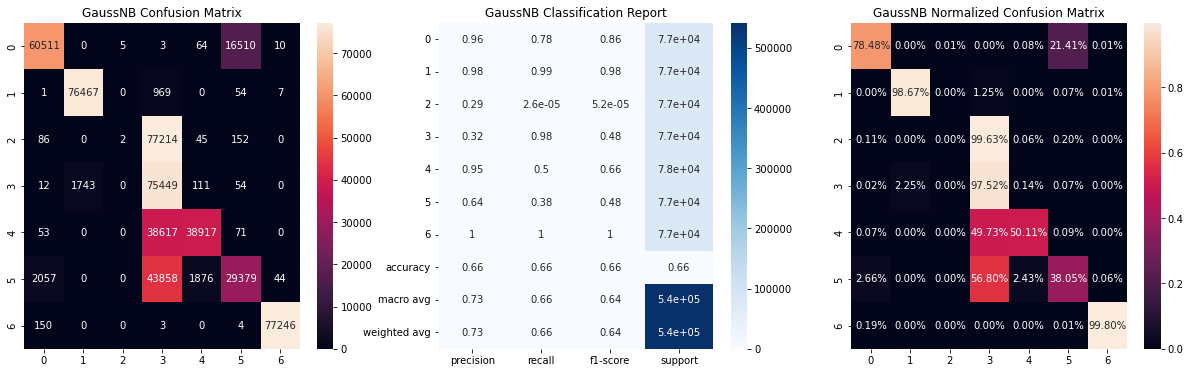

In [12]:
evaluation_test(GaussNB,'GaussNB')

In [ ]:
svvmm = SVM()